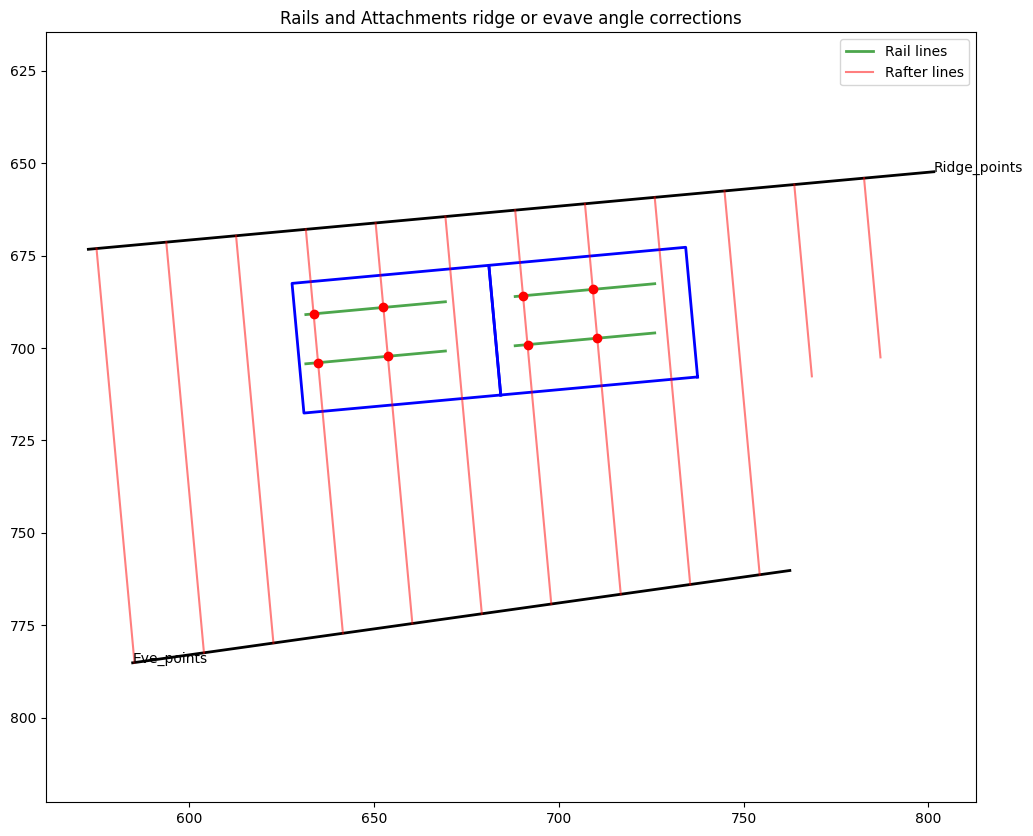

The attachment points are: [(709.180894015555, 684.1515400359749), (690.3022732394244, 685.8828746452812), (710.3924656223328, 697.3626205426187), (691.5138448462021, 699.093955151925), (652.5168211330902, 689.0379335675553), (633.6382003569597, 690.7692681768616), (653.7283927398679, 702.2490140741991), (634.8497719637375, 703.9803486835053)]


In [31]:
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import numpy as np


polygon_coords = [
    [
        (737.5289670029157, 707.8383607522512),
        (734.3115701872882, 672.7555904766095),
        (681.0581274146199, 677.639396853694),
        (684.2755242302474, 712.722167129336),
    ],
    [
        (684.2755242302474, 712.722167129336),
        (681.0581274146199, 677.639396853694),
        (627.8046846419517, 682.5232032307786),
        (631.0220814575791, 717.6059735064207),
    ]
]


after_firesetback_points = [
    [563.4131960920918, 683.849716230086],
    [571.2566964320002, 755.1586873236586],
    [721.4685234571397, 734.9041510984856],
    [718.5632461220539, 690.3538023020934],
    [758.5022503287624, 680.3684319624299],
    [757.2853517793179, 662.1138215783843],
    [563.4131960920918, 683.849716230086],
]



ridge_points = (
    [[801.448703847506, 652.3204787645773], [572.7011922497333, 673.298625861141]],
)
eve_points = (
    [[584.6879614164287, 785.1820770428143], [762.4917040557457, 760.208092404048]],
)


rafter_lines = [
    [[782.5700830713754, 654.0518133738835], [787.0169586488396, 702.5409253077241]],
    [[763.6914622952448, 655.7831479831898], [768.4505487273535, 707.6766338002399]],
    [[744.8128415191143, 657.514482592496], [754.3358016835114, 761.353655357538]],
    [[725.9342207429837, 659.2458172018023], [735.5405090690848, 763.9936073746672]],
    [[707.0555999668532, 660.9771518111086], [716.7452164546582, 766.6335593917966]],
    [[688.1769791907225, 662.7084864204148], [697.9499238402316, 769.2735114089259]],
    [[669.2983584145919, 664.4398210297212], [679.1546312258051, 771.9134634260552]],
    [[650.4197376384614, 666.1711556390275], [660.3593386113785, 774.5534154431845]],
    [[631.5411168623308, 667.9024902483337], [641.564045996952, 777.1933674603138]],
    [[612.6624960862002, 669.63382485764], [622.7687533825255, 779.8333194774431]],
    [[593.7838753100697, 671.3651594669462], [603.9734607680989, 782.4732714945724]],
    [[574.9052545339391, 673.0964940762525], [585.1781681536723, 785.1132235117018]],
]

# Create polygon objects
polygons = [Polygon(coords) for coords in polygon_coords]

# Calculate ridge angle
ridge_start, ridge_end = ridge_points[0]
ridge_dx = ridge_end[0] - ridge_start[0]
ridge_dy = ridge_end[1] - ridge_start[1]
ridge_angle = np.arctan2(ridge_dy, ridge_dx)

# Create vertical line segments as LineString objects
vertical_lines = []
for segment in rafter_lines:
    start, end = segment
    line = LineString([(start[0], start[1]), (end[0], end[1])])
    vertical_lines.append(line)

# Create ridge and eve lines
new_ridge_lines = []
new_eve_lines = []
for segment in ridge_points:
    start, end = segment
    line = LineString([(start[0], start[1]), (end[0], end[1])])
    new_ridge_lines.append(line)

for segment in eve_points:
    start, end = segment
    line = LineString([(start[0], start[1]), (end[0], end[1])])
    new_eve_lines.append(line)

# Create 2 horizontal lines per polygon that are aligned with ridge angle
horizontal_lines = []
# Create exactly 2 "horizontal" lines per polygon, aligned with ridge angle
for i, poly_coords in enumerate(polygon_coords):
    # Get polygon object
    polygon = polygons[i]
    
    # Calculate the y-range for this polygon
    y_coords = [y for _, y in poly_coords]
    poly_min_y = min(y_coords)
    poly_max_y = max(y_coords)
    
    # Create 2 evenly spaced "horizontal" lines within this specific polygon's y-range
    # These will now be parallel to the ridge line
    # Position them at 1/3 and 2/3 of the polygon height
    y1 = poly_min_y + (poly_max_y - poly_min_y) / 3
    y2 = poly_min_y + 2 * (poly_max_y - poly_min_y) / 3
    
    # Get leftmost and rightmost rafter lines that intersect with this polygon
    leftmost_x = float('inf')
    rightmost_x = float('-inf')
    leftmost_rafter = None
    rightmost_rafter = None
    
    for line in vertical_lines:
        x_coord = line.coords[0][0]
        if polygon.intersects(line):
            if x_coord < leftmost_x:
                leftmost_x = x_coord
                leftmost_rafter = line
            if x_coord > rightmost_x:
                rightmost_x = x_coord
                rightmost_rafter = line
    
    # If we found rafters, create "horizontal" lines that start and end at the rafters
    # and are aligned with the ridge angle
    if leftmost_rafter and rightmost_rafter:
        # Find points on leftmost and rightmost rafters at the desired heights
        # To do this, we need to shift the y-values according to the ridge angle
        
        # Calculate the horizontal distance between leftmost and rightmost rafters
        dx = rightmost_x - leftmost_x
        
        # Calculate the y-shift for the desired angle over the distance dx
        dy1 = dx * np.tan(ridge_angle)
        
        # Create lines parallel to ridge
        line1_start = (leftmost_x, y1)
        line1_end = (rightmost_x, y1 + dy1)
        line2_start = (leftmost_x, y2)
        line2_end = (rightmost_x, y2 + dy1)
        
        line1 = LineString([line1_start, line1_end])
        line2 = LineString([line2_start, line2_end])
        
        horizontal_lines.append(line1)
        horizontal_lines.append(line2)

# Calculate horizontal-vertical line intersections
h_v_intersections = []
for polygon in polygons:
    for h_line in horizontal_lines:
        for v_line in vertical_lines:
            h_v_point = h_line.intersection(v_line)
            if not h_v_point.is_empty and polygon.contains(h_v_point):
                h_v_intersections.append((h_v_point.x, h_v_point.y))

# Plot everything
plt.figure(figsize=(12, 10))

# Plot polygons
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y, 'b-', linewidth=2)

# Plot ridge line
for points in new_ridge_lines:
    x, y = points.xy
    plt.plot(x, y, 'k-', linewidth=2)
    plt.text(x[0], y[0], 'Ridge_points', fontsize=10)

# Plot eve line
for points in new_eve_lines:
    x, y = points.xy
    plt.plot(x, y, 'k-', linewidth=2)
    plt.text(x[0], y[0], 'Eve_points', fontsize=10)

# Plot horizontal lines (adjusted to ridge angle)
for line in horizontal_lines:
    x, y = line.xy
    plt.plot(x, y, 'g-', alpha=0.7, linewidth=2, label='Rail lines')

# Plot vertical lines (rafters)
for line in vertical_lines:
    x, y = line.xy
    plt.plot(x, y, 'r-', alpha=0.5, label='Rafter lines')

# Plot attachment points (intersections)
for point in h_v_intersections:
    plt.plot(point[0], point[1], 'ro', markersize=6)

# Get all x and y values for plot limits
x_values = [coord[0] for poly in polygon_coords for coord in poly] + [seg[0][0] for seg in rafter_lines] + [seg[1][0] for seg in rafter_lines]
y_values = [coord[1] for poly in polygon_coords for coord in poly] + [seg[0][1] for seg in rafter_lines] + [seg[1][1] for seg in rafter_lines]

# Set plot limits with some padding
plt.xlim(min(x_values) - 50, max(x_values) + 50)
plt.ylim(min(y_values) - 50, max(y_values) + 50)

plt.title('Rails and Attachments ridge or evave angle corrections')
plt.grid(False)
# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.axis('equal')
plt.gca().invert_yaxis()
plt.show()

# Print attachment points
attachment_points = [item for item in h_v_intersections]
print("The attachment points are:", attachment_points)

In [ ]:
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import numpy as np

points = [{'x': 866.5399899872009, 'y': 659.9121564253597}, {'x': 875.338800284868, 'y': 753.7885971971191}, {'x': 847.6648730310452, 'y': 661.6812751955022}, {'x': 856.470951752996, 'y': 755.6352643833216}, {'x': 828.7897560748895, 'y': 663.4503939656446}, {'x': 837.6031032211243, 'y': 757.481931569524}, {'x': 809.9146391187339, 'y': 665.219512735787}, {'x': 818.7352546892527, 'y': 759.3285987557256}, {'x': 791.0395221625782, 'y': 666.9886315059294}, {'x': 805.6446941332941, 'y': 822.8144210258861}, {'x': 772.1644052064225, 'y': 668.7577502760719}, {'x': 790.967365465647, 'y': 869.3706655899614}, {'x': 753.2892882502668, 'y': 670.5268690462143}, {'x': 772.1767533211356, 'y': 872.041384767077}, {'x': 734.4141712941112, 'y': 672.2959878163567}, {'x': 753.3861411766243, 'y': 874.7121039441926}, {'x': 715.5390543379556, 'y': 674.0651065864992}, {'x': 734.5955290321131, 'y': 877.3828231213082}, {'x': 696.6639373817998, 'y': 675.8342253566416}, {'x': 715.8049168876015, 'y': 880.0535422984238}, {'x': 677.7888204256442, 'y': 677.603344126784}, {'x': 697.0143047430903, 'y': 882.7242614755394}, {'x': 658.9137034694885, 'y': 679.3724628969264}, {'x': 678.2236925985789, 'y': 885.394980652655}, {'x': 640.0385865133328, 'y': 681.1415816670689}, {'x': 659.4330804540676, 'y': 888.0656998297707}, {'x': 621.1634695571772, 'y': 682.9107004372113}, {'x': 640.6424683095562, 'y': 890.7364190068863}, {'x': 602.2883526010215, 'y': 684.6798192073537}, {'x': 621.8518561650449, 'y': 893.4071381840018}, {'x': 583.4132356448658, 'y': 686.4489379774961}, {'x': 603.0612440205334, 'y': 896.0778573611175}, {'x': 564.5381186887103, 'y': 688.2180567476386}, {'x': 584.2706318760222, 'y': 898.748576538233}, {'x': 545.6630017325544, 'y': 689.987175517781}, {'x': 565.4800197315108, 'y': 901.4192957153487}, {'x': 526.7878847763989, 'y': 691.7562942879234}, {'x': 546.6894075869994, 'y': 904.0900148924643}, {'x': 507.9127678202432, 'y': 693.5254130580659}, {'x': 527.8987954424881, 'y': 906.7607340695799}, {'x': 489.03765086408754, 'y': 695.2945318282083}, {'x': 509.1081832979767, 'y': 909.4314532466955}, {'x': 470.1625339079319, 'y': 697.0636505983507}, {'x': 490.31757115346545, 'y': 912.1021724238111}, {'x': 451.2874169517762, 'y': 698.8327693684931}, {'x': 471.52695900895407, 'y': 914.7728916009268}, {'x': 432.4122999956206, 'y': 700.6018881386356}, {'x': 452.73634686444274, 'y': 917.4436107780423}]


for item in 

array('d', [460.2808112324493, 865.6474258970359, 854.6645865834633, 852.6677067082684, 848.6739469578783, 812.7301092043682, 808.7363494539782, 850.6708268330733, 839.6879875195008, 848.6739469578783, 451.2948517940718, 460.2808112324493])